# Compare policies with ground truth
This notebook demonstrates how our simulation framework can be used to configure environments to create logs and ground truths for evaluation of different strategies. As an example, we compare Qini estimates of cluster level treatments (where all items within a cluster get the same treatment) and individual level treatments (where each item within a cluster gets a separate treatment). We demonstrate how using standard Qini estimates on individual-level-treatments does not present accurate performance estimates.

In this notebook, we refer to clusters as users, and individuals as items. This represents a standard ecommerce setup. 
 

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from infsim.environments.base_simulator import BaseEnvironment
from infsim.policies.user_policies import user_level_control_policy, ground_truth_based_user_level_uplift_policy
from infsim.policies.item_policies import ground_truth_based_item_level_uplift_policy
from infsim.utils.attractiveness import user_item_attractiveness
from infsim.utils.context_sampler import UniformContextSampler
from infsim.utils.conversion_sampling import softmax_exp_decay_conversion_sampler
from infsim.utils.evaluation import create_buckets_from_scores, compute_incremental_metrics


### Defining the simulation environment
In order to simulate how we evaluate policies in the real world, we need to start by collecting control group data. 

For this, we create a simulation environment and interact with it using a control policy.


All simulations have four base elements:

1. `context_sampler`, which samples user and item contexts. In our case, we pick a simple uniform random context sampler, where each feature is an independent uniform random value. 
2. `attractiveness_function`, which maps each context to an item's attractiveness. We use the default `user_item_attractiveness` methods for this.
3. `conversion_sampler`, which transforms the item `attractiveness` to conversion probabilities and observed conversions. In our case, we use a softmax-exp-decay conversion sampler, which sums the top attractiveness weighted by an exponential decay to get the probability that a user converts, and samples an item to convert based on a softmax (only if a conversion takes place). For the softmax, we set the temperature to 0.1.
4. `policy`, our data collection policy. This policy is used to collect logs that can be used for simulating production training and evaluation. We pick a user-level control policy that assigns treatment to each user in a 50-50 split. 


In [3]:
context_sampler = UniformContextSampler(
    n_items=10,
    n_item_features=4,
    n_user_features=5,
    seed=42
)

env = BaseEnvironment(
    context_sampler=context_sampler,
    attractiveness_function=user_item_attractiveness,
    conversion_sampler=partial(softmax_exp_decay_conversion_sampler, temperature=0.1),
    policy=user_level_control_policy,
    seed=43,
)

#### Generating logs from the simulated environment
Using the environment we defined, we can generate any amount of logs.   

In [ ]:
logs = env.step(1_000_000)



#### Creating a policy to evaluate 
In this example, we generate a user-level policy that has access to the ground truth of the simulator. This policy is created such that higher scores guarantee higher conversion (ignoring other economics).

We define this method using a `partial` definition such that we can pass additional values that are not standard for policies that do not have access to ground-truth data.

In [ ]:
user_level_policy = partial(
    ground_truth_based_user_level_uplift_policy,
    discount_percentage=logs.discount_percentage,
    attractiveness_func=partial(env.attractiveness_function, seed=env.seed),
    noise=0.00,
)

user_level_policy_logs = env.resample_with_alternative_policy(logs, user_level_policy)


#### Assigning buckets to each prediction
For offline evaluation, we need to create buckets that represent different model thresholds for treatment. 

The logistics get a little complicated here, because we want to evaluate our new policy using the data collected by the randomised policy. The means that we copy the logging policy and only add the bucket assignment based on the new policy (evaluation policy) to this dataframe. More data from the evaluation policy is not needed.   


In [6]:
model_scores = user_level_policy_logs.item_context.model_score + np.random.uniform(1e-15, 1e-14, size=len(user_level_policy_logs.item_context.model_score))
item_context = logs.item_context.copy()
item_context["bucket"] = create_buckets_from_scores(model_scores, n_buckets=10, max_relative_size=1.05)

#### Ground truth evaluation
Because we are using a simulator, we have access to a ground truth uplift-curve. The simulation framework exposes a `compute_incremental_metrics` method which does just that.

Keep in mind that computing the incremental metrics can be somewhat computationally expensive, so this step might take a minute. 

Text(0, 0.5, 'Expected Incremental Profit')

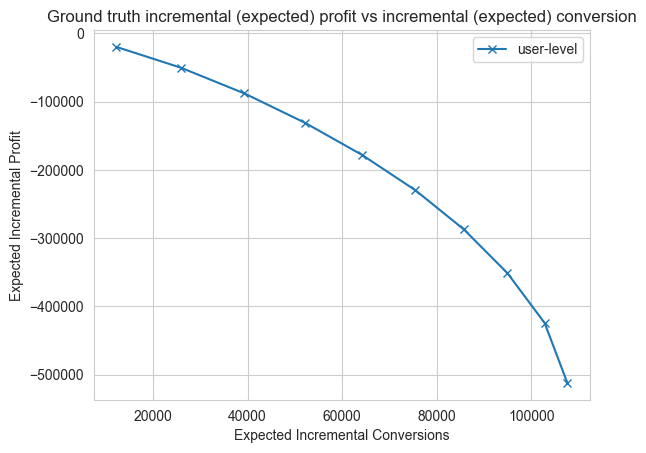

In [7]:
incremental_metrics_user_level = compute_incremental_metrics(env, user_level_policy_logs, item_context["bucket"])

fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')

ax.plot(incremental_metrics_user_level["expected_incr_conversions"][1:], incremental_metrics_user_level["expected_incr_profit"][1:], marker='x', label=f"user-level")


ax.legend()
ax.set_title("Ground truth incremental (expected) profit vs incremental (expected) conversion")
ax.set_xlabel("Expected Incremental Conversions")
ax.set_ylabel("Expected Incremental Profit")


#### Plotting the uplift curve
Using the `compute_qini_metrics` method defined below, we can estimate the performance of our policy using the existing control logs. As can be seen in the plot below, using this strategy we get an estimate that is almost identical to the ground-truth estimate. This is possible, because there is no interference between users. 

In [ ]:
def compute_qini_metrics(item_context, logs):
    item_context["price"] = logs.price
    item_context["commission"] = logs.commission_percentage

    reservations = item_context[item_context.is_converted == 1]
    reservations["commission_value"] = reservations["price"] * (
        reservations["commission"] / 100
    )
    reservations["discount_value"] = (
        reservations["price"] * reservations["is_treated"] * logs.discount_percentage
    )

    cumulative_profit = []
    cumulative_conversion = []
    for bucket in range(-1, reservations["bucket"].max() + 1):
        b_data_treated = reservations[(reservations["bucket"] <= bucket) & (reservations["is_treated"] == 1)]
        b_data_holdout = reservations[(reservations["bucket"] <= bucket) & (reservations["is_treated"] == 0)]
    
        cumulative_conversion.append((b_data_treated["is_converted"].sum() - (b_data_holdout["is_converted"].sum())) * 2)
        cumulative_profit.append(((b_data_treated["commission_value"] - b_data_treated["discount_value"]).sum() - ((b_data_holdout["commission_value"] - b_data_holdout["discount_value"]).sum())) * 2)
    
    metrics = {}
    metrics["cumulative_profit"] = np.asarray(cumulative_profit)
    metrics["cumulative_conversion"] = np.asarray(cumulative_conversion)
    
    metrics["incremental_profit"] = cumulative_profit[1:] - cumulative_profit[0]
    metrics["incremental_conversion"] = cumulative_conversion[1:] - cumulative_conversion[0]
    
    return metrics

user_qini = compute_qini_metrics(item_context, logs)

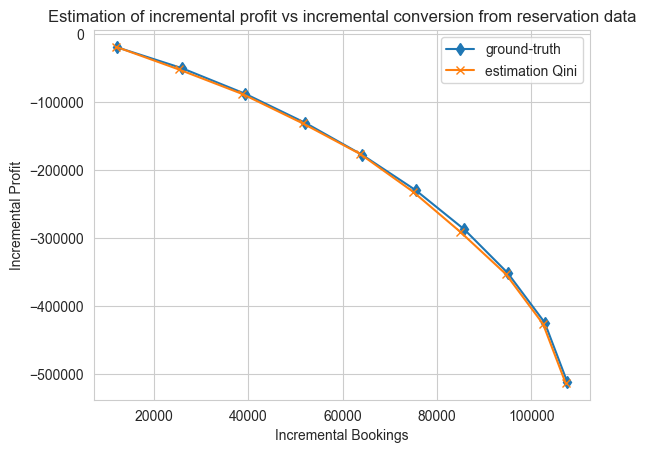

In [9]:
plt.title("Estimation of incremental profit vs incremental conversion from reservation data")

plt.xlabel("Incremental Bookings")
plt.ylabel("Incremental Profit")
plt.plot(incremental_metrics_user_level["expected_incr_conversions"][1:], incremental_metrics_user_level["expected_incr_profit"][1:], marker='d', label=f"ground-truth")
plt.plot(user_qini["incremental_conversion"], user_qini["incremental_profit"], marker='x', label=f"estimation Qini")

plt.legend()


### Compare estimation of item- and user-level policies using ground truth and offline estimation
The data above is collected at a user-level. In the next section, we demonstrate that although the user-level policy can be estimated accurately, this not the case for item-level policies. 

In [10]:
item_level_policy = partial(
    ground_truth_based_item_level_uplift_policy,
    discount_percentage=logs.discount_percentage,
    attractiveness_func=partial(env.attractiveness_function, seed=env.seed),
    noise=0.00,
)

_, item_level_model_scores = item_level_policy(logs.user_context, logs.item_context, rng=np.random.default_rng(42))

In [11]:
item_level_item_context = logs.item_context.copy()
item_level_item_context["bucket"] = create_buckets_from_scores(item_level_model_scores.model_score, n_buckets=10)

In [ ]:
item_qini = compute_qini_metrics(item_level_item_context, logs)

Text(0, 0.5, 'Incremental Profit')

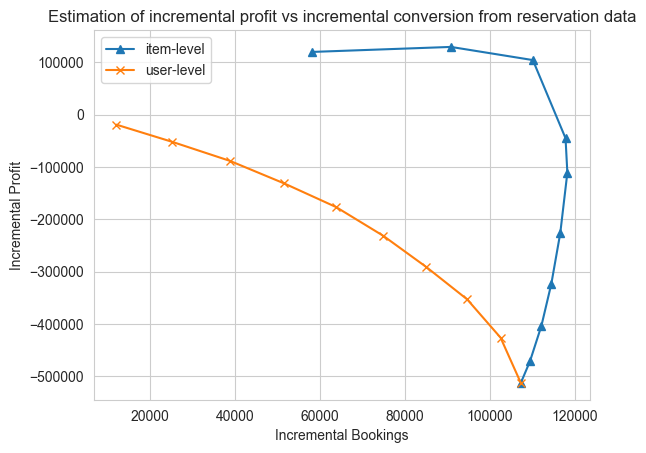

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')

plt.plot(item_qini["incremental_conversion"], item_qini["incremental_profit"], marker='^', label=f"item-level")
plt.plot(user_qini["incremental_conversion"], user_qini["incremental_profit"], marker='x', label=f"user-level")

ax.legend()
ax.set_title("Estimation of incremental profit vs incremental conversion from reservation data")

ax.set_xlabel("Incremental Bookings")
ax.set_ylabel("Incremental Profit")


In [13]:
item_level_policy_logs = env.resample_with_alternative_policy(logs, item_level_policy)

assigned_buckets_item_level = create_buckets_from_scores(item_level_policy_logs.item_context.model_score, n_buckets=10)

incremental_metrics_item_level = compute_incremental_metrics(env, item_level_policy_logs, assigned_buckets_item_level)

Text(0, 0.5, 'Expected Incremental Profit')

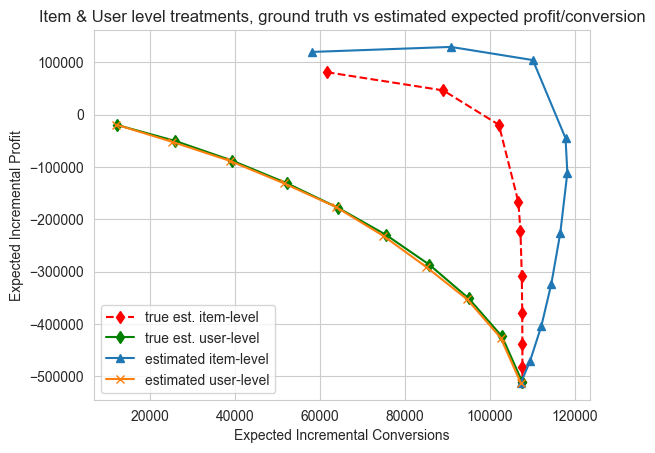

In [14]:
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')

ax.plot(incremental_metrics_item_level["expected_incr_conversions"][1:], incremental_metrics_item_level["expected_incr_profit"][1:], linestyle="--",marker='d', color="red", label=f"true est. item-level")
ax.plot(incremental_metrics_user_level["expected_incr_conversions"][1:], incremental_metrics_user_level["expected_incr_profit"][1:], marker='d', color="green", label=f"true est. user-level")

plt.plot(item_qini["incremental_conversion"], item_qini["incremental_profit"], marker='^', label=f"estimated item-level")
plt.plot(user_qini["incremental_conversion"], user_qini["incremental_profit"], marker='x', label=f"estimated user-level")

ax.legend()
ax.set_title("Item & User level treatments, ground truth vs estimated expected profit/conversion")
ax.set_xlabel("Expected Incremental Conversions")
ax.set_ylabel("Expected Incremental Profit")
